In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report, f1_score,recall_score,accuracy_score,roc_auc_score,precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sb
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# **GLoVe w BiLSTM**

In [ ]:
#load csv files
df = pd.read_csv("/content/gdrive/MyDrive/CS3244/CS3244/Final/Updated/full_train_preprocessed_subset.csv")
df = df.drop(columns=['Unnamed: 0'])

df_val = pd.read_csv("/content/gdrive/MyDrive/CS3244/CS3244/Final/Updated/full_val_preprocessed_subset.csv")
df_val = df_val.drop(columns=['Unnamed: 0'])

df_test = pd.read_csv("/content/gdrive/MyDrive/CS3244/CS3244/Final/Updated/full_test_preprocessed_subset.csv")
df_test = df_test.drop(columns=['Unnamed: 0'])

df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,annotations,text,hashtag,tokens,upper_case,num_digits,num_hashtags,num_words,average_word_length,positive,neutral,negative,compound,label
0,1384,Nobody go to Walmart in sulphur,NaN,"['nobody', 'go', 'walmart', 'sulphur']",2,0,1,6,4.333333,0.0,1.0,0.0,0.0,2
1,1384,@emberlhamon @MLidak welcome to the ugly club!!,NaN,"['welcome', 'ugly', 'club']",2,0,1,8,5.125000,0.0,1.0,0.0,0.0,2
2,1384,getting to help coach jr high,NaN,"['getting', 'help', 'coach', 'jr', 'high']",0,0,1,6,4.000000,0.0,1.0,0.0,0.0,2
3,1384,Yo Gotti and Black Youngsta on stage we all th...,NaN,"['yo', 'gotti', 'black', 'youngsta', 'stage', ...",4,0,1,13,3.692308,0.0,1.0,0.0,0.0,2
4,1384,@spenceribarra just making sure I haven't been...,NaN,"['making', 'sure', 'havent', 'replaced']",1,0,1,9,5.333333,0.0,1.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133994,1392,Agape Worshippers their voices are so angelic...,NaN,"['agape', 'worshipper', 'voice', 'angelic', 'g...",3,0,1,12,5.000000,0.0,1.0,0.0,0.0,3
133995,1392,@abike \nHe's a cutie,NaN,"['he', 'cutie']",1,0,1,5,3.400000,0.0,1.0,0.0,0.0,3
133996,1392,@Americooligan thanks,NaN,['thanks'],1,0,1,3,6.666667,0.0,1.0,0.0,0.0,3
133997,1392,Ari's mom braided my hair,NaN,"['aris', 'mom', 'braided', 'hair']",1,0,1,6,3.500000,0.0,1.0,0.0,0.0,3


In [ ]:
from ast import literal_eval
import re

def clean_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

def join_text(x):
  return clean_text(x)
df["text_clean"] = df["text"].apply(lambda x: join_text(x))
df_val["text_clean"] = df_val["text"].apply(lambda x: join_text(x))
df_test["text_clean"] = df_test["text"].apply(lambda x: join_text(x))

In [ ]:
df["text_clean"]

0                           Nobody go to Walmart in sulphur
1              emberlhamon MLidak welcome to the ugly club 
2                             getting to help coach jr high
3         Yo Gotti and Black Youngsta on stage we all th...
4          spenceribarra just making sure I haven t been...
                                ...                        
133994    Agape Worshippers their voices are so angelic ...
133995                                  abike He s a cutie 
133996                                Americooligan thanks 
133997                           Ari s mom braided my hair 
133998                                       RT shwetavyas 
Name: text_clean, Length: 133999, dtype: object

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = df["text_clean"], df["label"], df_val["text_clean"], df_val["label"], df_test["text_clean"], df_test["label"]

In [ ]:
embed_file = '/content/gdrive/MyDrive/CS3244/CS3244/Glove Embeddings/glove.twitter.27B.100d.txt'

In [ ]:
!pip install keras
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.values)

word_index = tokenizer.word_index

sentence_train = tokenizer.texts_to_sequences(X_train.values)
X_train_padding = pad_sequences(sentence_train, padding='post', maxlen = 22)
sentence_val = tokenizer.texts_to_sequences(X_val.values)
X_val_padding = pad_sequences(sentence_val, padding='post', maxlen = 22)
sentence_test= tokenizer.texts_to_sequences(X_test.values)
X_test_padding = pad_sequences(sentence_test, padding='post', maxlen = 22)
vocab_size = len(word_index) + 1

In [ ]:
glove2vector = {}

with open(embed_file, 'rb') as f:
  for l in f:
    line = l.decode().split()
    word = line[0]
    vect = np.array(line[1:]).astype(np.float)
    glove2vector[word] = vect 

f.close()
print('Total %s word vectors.' % len(glove2vector))

len(glove2vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


Total 1193515 word vectors.


1193515

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = glove2vector.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
import tensorflow.keras.layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
max_length = 100
embedding_layer = Embedding(vocab_size,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=X_train_padding.shape[1],
                            trainable=False)

In [ ]:
from tensorflow.keras.models import Sequential
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(150, return_sequences=True)), 
    Dropout(0.4),
    Bidirectional(LSTM(150)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

log_folder = 'logs'
callbacks = [
            EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 5, restore_best_weights = True, verbose = 1),
            TensorBoard(log_dir=log_folder)
            ]
num_epochs = 25
history = model.fit(X_train_padding, y_train, epochs=num_epochs, batch_size=32,shuffle=True, callbacks=callbacks, validation_data=(X_val_padding, y_val), verbose=1)

Epoch 1/25
4188/4188 [==============================] - 74s 15ms/step - loss: 1.3410 - accuracy: 0.4150 - val_loss: 1.3083 - val_accuracy: 0.4340
Epoch 2/25
4188/4188 [==============================] - 62s 15ms/step - loss: 1.2911 - accuracy: 0.4430 - val_loss: 1.2867 - val_accuracy: 0.4454
Epoch 3/25
4188/4188 [==============================] - 62s 15ms/step - loss: 1.2609 - accuracy: 0.4571 - val_loss: 1.2746 - val_accuracy: 0.4506
Epoch 4/25
4188/4188 [==============================] - 59s 14ms/step - loss: 1.2316 - accuracy: 0.4716 - val_loss: 1.2738 - val_accuracy: 0.4511
Epoch 5/25
4188/4188 [==============================] - 59s 14ms/step - loss: 1.1990 - accuracy: 0.4876 - val_loss: 1.2819 - val_accuracy: 0.4500
Epoch 6/25
4188/4188 [==============================] - 58s 14ms/step - loss: 1.1622 - accuracy: 0.5040 - val_loss: 1.2886 - val_accuracy: 0.4536
Epoch 7/25
4188/4188 [==============================] - 60s 14ms/step - loss: 1.1231 - accuracy: 0.5221 - val_loss: 1.3005 -

In [ ]:
model.evaluate(X_test_padding, y_test)

534/534 [==============================] - 3s 6ms/step - loss: 1.3150 - accuracy: 0.4493


[1.314955472946167, 0.4492762088775635]

In [ ]:
predictions_glove = model.predict(X_test_padding)
preds_classes_glove = np.argmax(predictions_glove,axis=1)

534/534 [==============================] - 4s 7ms/step


In [ ]:
print(accuracy_score(y_test,preds_classes_glove))
print(classification_report(y_test,preds_classes_glove))

0.44927621168610443
              precision    recall  f1-score   support

           0       0.46      0.72      0.56      3934
           1       0.44      0.32      0.37      3546
           2       0.39      0.25      0.31      2911
           3       0.50      0.48      0.49      3619
           4       0.41      0.40      0.41      3053

    accuracy                           0.45     17063
   macro avg       0.44      0.44      0.43     17063
weighted avg       0.44      0.45      0.44     17063



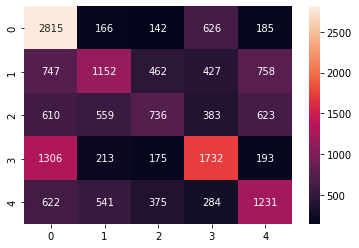

In [ ]:
cf_matrix_glove = confusion_matrix(y_test,preds_classes_glove)  
sb.heatmap(cf_matrix_glove, annot=True, fmt='g')

In [ ]:
import pickle
filename = 'LSTM_train_withHashtags.sav'
pickle.dump(model, open(f"/content/gdrive/MyDrive/CS3244/CS3244/{filename}", 'wb'))

# **GLoVe w BiLSTM Tuned**

In [ ]:
import pickle
filename = '/content/gdrive/MyDrive/CS3244/CS3244/LSTM_train_withHashtags.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 55.8 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = glove2vector.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
max_length = 100
embedding_layer = Embedding(vocab_size,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=X_train_padding.shape[1],
                            trainable=False)

In [ ]:
def model_builder(hp):
    model = Sequential()
    
    model.add(
        Embedding(vocab_size,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=X_train_padding.shape[1],
                            trainable=False))
    hp_lstm_units1 = hp.Int('bilstm_units1', 
                            min_value=32, 
                            max_value=512, 
                            step=32)
    model.add(Bidirectional(LSTM(hp_lstm_units1,return_sequences=True)))
    hp_dropout_rate1 = hp.Float('dropout_rate1', 
                               min_value=0.6, 
                               max_value=0.9, 
                               step=0.1)
    model.add(Dropout(hp_dropout_rate1))
    
    hp_lstm_units2 = hp.Int('bilstm_units2', 
                            min_value=16, 
                            max_value=512, 
                            step=32)
    model.add(Bidirectional(LSTM(hp_lstm_units2)))
    hp_dropout_rate2 = hp.Float('dropout_rate2', 
                               min_value=0.6, 
                               max_value=0.9, 
                               step=0.1)
    model.add(Dropout(hp_dropout_rate2))

    hp_dense = hp.Int('dense_unit', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_dense,activation='relu'))

    model.add(Dense(5,activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
import keras

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

In [ ]:
import tensorflow as tf
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train_padding, y_train, epochs=25, batch_size=32,shuffle=True, callbacks=[stop_early], validation_data=(X_val_padding, y_val))

Trial 30 Complete [00h 11m 57s]
val_accuracy: 0.4522441029548645

Best val_accuracy So Far: 0.4547988176345825
Total elapsed time: 00h 53m 06s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

log_folder = 'logs'
callbacks = [
            EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 5, restore_best_weights = True, verbose = 1),
            TensorBoard(log_dir=log_folder)
            ]

In [ ]:
model_tune = tuner.hypermodel.build(best_hps)
history = model_tune.fit(X_train_padding, y_train, epochs=25, batch_size=32,shuffle=True, callbacks=callbacks, validation_data=(X_val_padding, y_val), verbose=1)

Epoch 1/25
4188/4188 [==============================] - 68s 15ms/step - loss: 1.3548 - accuracy: 0.4091 - val_loss: 1.3196 - val_accuracy: 0.4290
Epoch 2/25
4188/4188 [==============================] - 58s 14ms/step - loss: 1.3048 - accuracy: 0.4370 - val_loss: 1.2963 - val_accuracy: 0.4387
Epoch 3/25
4188/4188 [==============================] - 58s 14ms/step - loss: 1.2749 - accuracy: 0.4531 - val_loss: 1.2819 - val_accuracy: 0.4495
Epoch 4/25
4188/4188 [==============================] - 58s 14ms/step - loss: 1.2449 - accuracy: 0.4671 - val_loss: 1.2832 - val_accuracy: 0.4497
Epoch 5/25
4188/4188 [==============================] - 56s 13ms/step - loss: 1.2127 - accuracy: 0.4819 - val_loss: 1.2795 - val_accuracy: 0.4497
Epoch 6/25
4188/4188 [==============================] - 59s 14ms/step - loss: 1.1743 - accuracy: 0.5007 - val_loss: 1.2876 - val_accuracy: 0.4488
Epoch 7/25
4188/4188 [==============================] - 56s 13ms/step - loss: 1.1316 - accuracy: 0.5214 - val_loss: 1.2972 -

In [ ]:
model_tune.evaluate(X_test_padding,y_test)

534/534 [==============================] - 3s 7ms/step - loss: 1.3228 - accuracy: 0.4453


[1.3227531909942627, 0.4453495740890503]

In [ ]:
predictions_tune = model_tune.predict(X_test_padding)
preds_classes_tune = np.argmax(predictions_tune,axis=1)

534/534 [==============================] - 4s 5ms/step


In [ ]:
print(accuracy_score(y_test,preds_classes_tune))
print(classification_report(y_test,preds_classes_tune))

0.4453495868252945
              precision    recall  f1-score   support

           0       0.46      0.67      0.55      3934
           1       0.41      0.34      0.37      3546
           2       0.39      0.28      0.33      2911
           3       0.48      0.50      0.49      3619
           4       0.43      0.37      0.40      3053

    accuracy                           0.45     17063
   macro avg       0.44      0.43      0.43     17063
weighted avg       0.44      0.45      0.44     17063



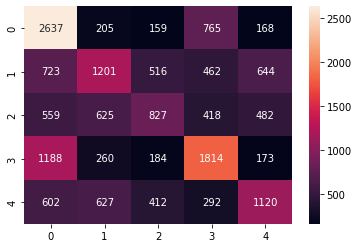

In [ ]:

cf_matrix_tune = confusion_matrix(y_test,preds_classes_tune)  
sb.heatmap(cf_matrix_tune, annot=True, fmt='g')